In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import predict

# utils for SmoothGrad technique
from utils import get_averaged_grad, preprocess_grad, get_predictions,\
    preprocess_image, unpreprocess_image, show

torch.cuda.is_available()

True

# Load the model

In [3]:
sys.path.append('../densenet/')
from get_densenet121 import get_model

In [4]:
_, val_folder = get_folders()

In [5]:
# decode: folder name to class name (in human readable format)
_, decode = get_class_weights(val_folder.class_to_idx)

In [6]:
model, _, _ = get_model()
# load pretrained model
model.load_state_dict(torch.load('../densenet/model121.pytorch_state'))

for p in model.parameters():
    p.requires_grad = False
    
model.eval();

# Load some images

In [7]:
data_dir = '/home/ubuntu/data/'
files = [
    # from train set
    'train/100/10309_100_0039.jpg', 'train/170/17349_170_0010.jpg', 
    'train/190/19304_190_0026.jpg', 'train/190/19306_190_0074.jpg',
    'train/162/16567_162_0077.jpg', 'train/166/16982_166_0073.jpg',
    'train/104/10742_104_0014.jpg', 'train/108/11151_108_0024.jpg',
    'train/133/13670_133_0009.jpg', 'train/8/871_008_0078.jpg',
    'train/114/11788_114_0018.jpg', 'train/210/21347_210_0011.jpg',
    # from val set
    'val/112/112_0057.jpg', 'val/13/013_0001.jpg',
    'val/15/015_0074.jpg', 'val/17/017_0027.jpg',
    'val/28/028_0037.jpg', 'val/141/141_0081.jpg',
    'val/144/144_0009.jpg', 'val/146/146_0057.jpg'
]

In [8]:
images = []
classes = [] # corresponding true classes 
for name in files:
    
    # get image
    file_path = data_dir + name
    image = Image.open(file_path)
    array = np.asarray(image, dtype='float32')
    
    images.append(array/255.0)
    folder_number = name.split('/')[1]
    classes.append((
        decode[int(folder_number)], # human readable format
        val_folder.class_to_idx[folder_number] # index in the model's output
    ))

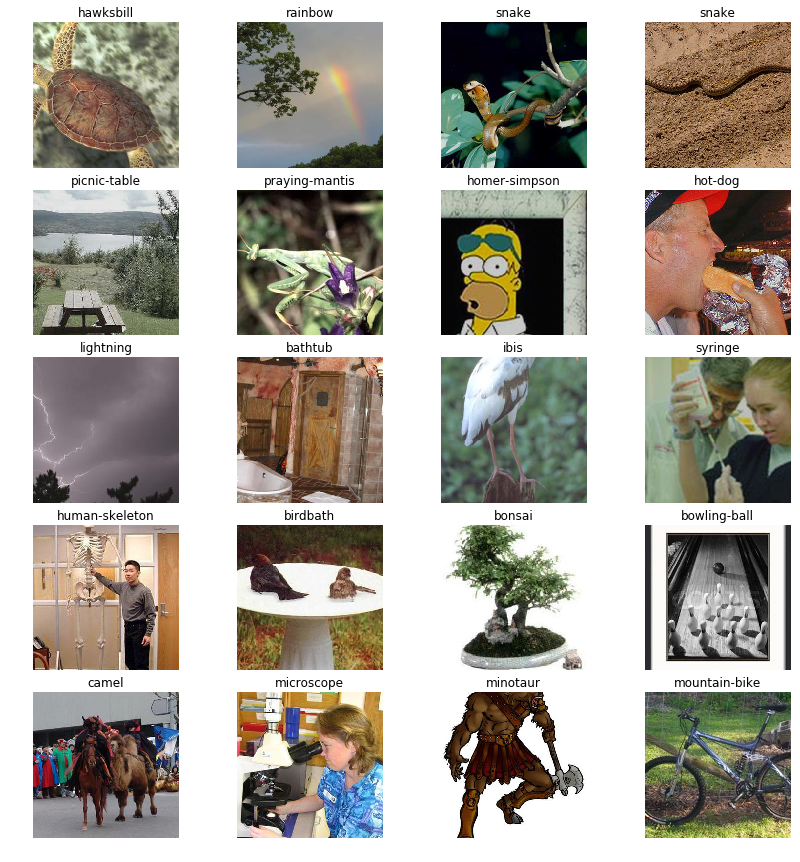

In [9]:
# show images
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 15))
axes = axes.flatten()
for i, img in enumerate(images):
    axes[i].set_axis_off();
    axes[i].imshow(img);
    axes[i].set_title(classes[i][0]);

plt.subplots_adjust(wspace=None, hspace=0.15)

In [10]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

# Compute grads with respect to images

In [11]:
%%time
image_grads = []
image_preds = []

for i in range(len(images)):
    
    img = preprocess_image(images[i])
    
    # grads of the true class' probability are computed
    img_grad = get_averaged_grad(
        img, class_to_use=classes[i][1], n_samples=50, model=model
    )
    
    # prepare grad for visualization
    img_grad = preprocess_grad(img_grad)
    
    # also get all predictions for img
    img_pred = get_predictions(img, model)
    
    image_grads.append(img_grad)
    image_preds.append(img_pred)

CPU times: user 49.1 s, sys: 1.62 s, total: 50.7 s
Wall time: 43.1 s


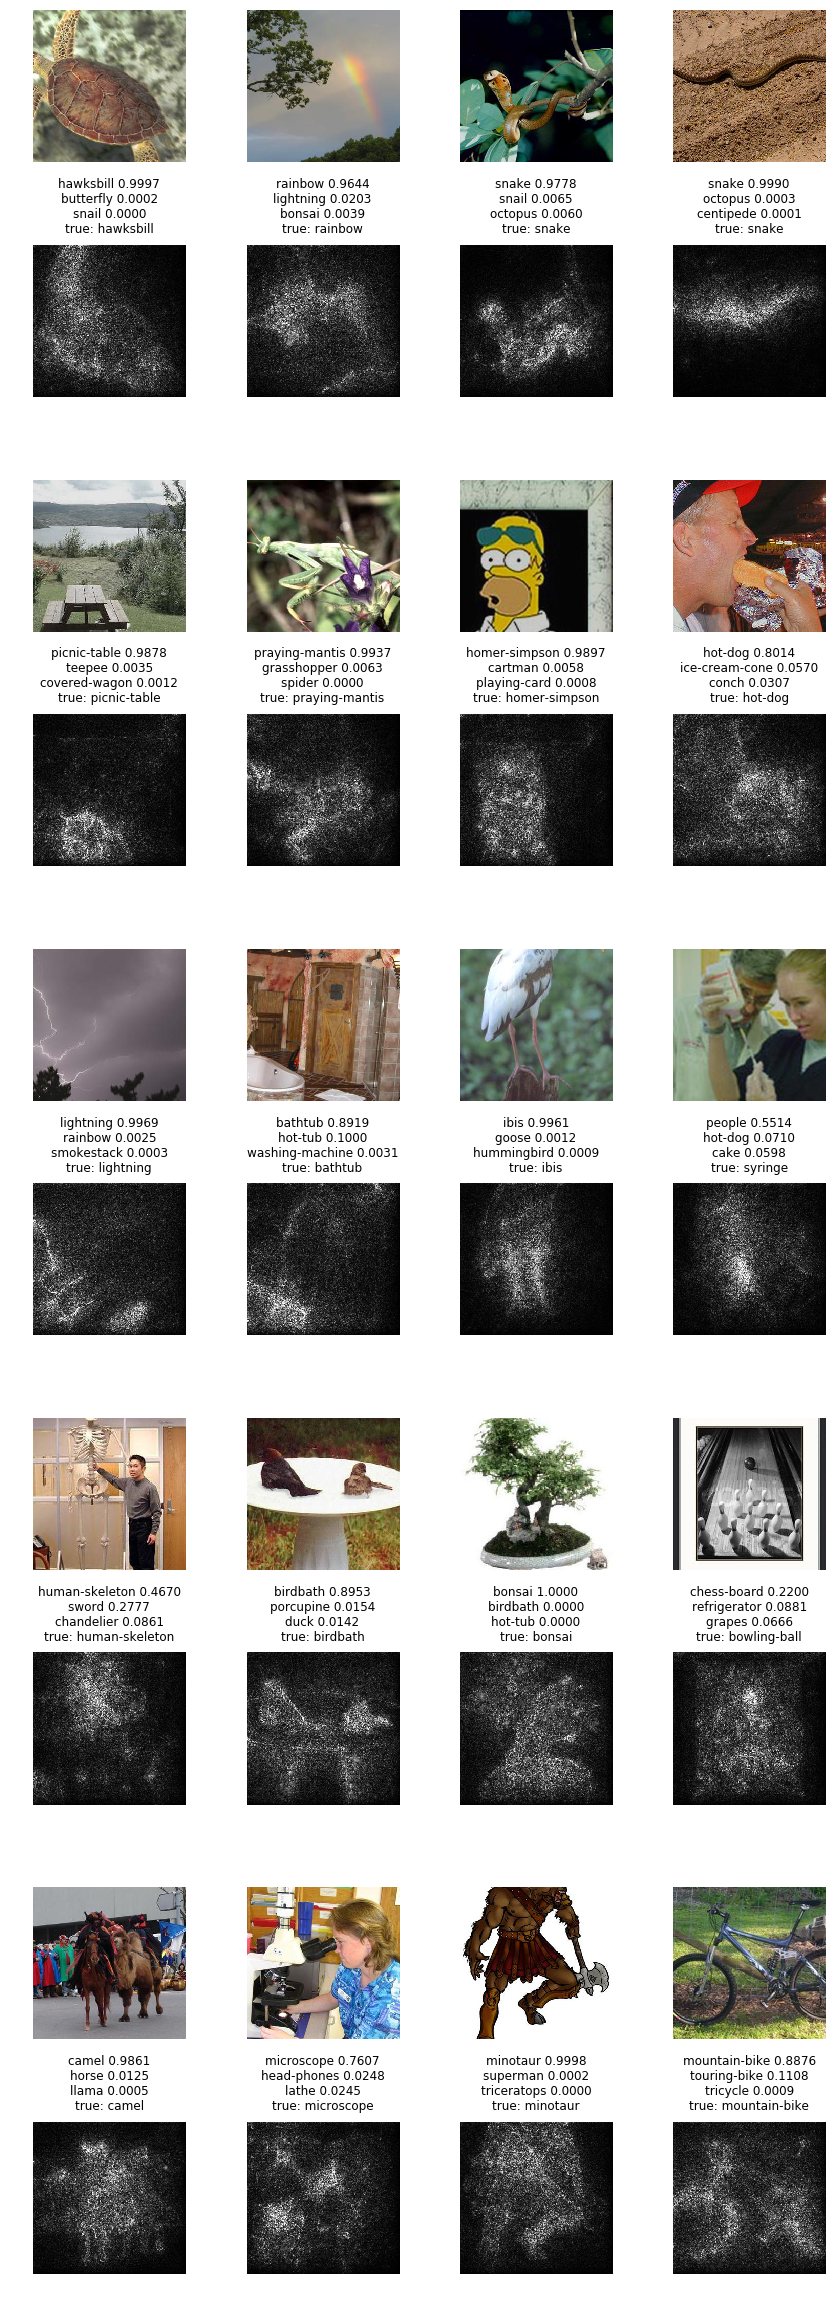

In [12]:
show(
    images, classes, image_grads, image_preds, decode, 
    file_to_save='sensitivity_maps1.png'
)

# Explore some misclassified images 

In [13]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [14]:
_, _, erroneous_samples, erroneous_targets, erroneous_predictions = predict(
    model, val_iterator_no_shuffle, return_erroneous=True
)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 80/80 [00:31<00:00,  2.64it/s]


In [15]:
# choose 20 random images to show
n_errors = len(erroneous_samples)
rows = np.random.choice(np.arange(0, n_errors), size=20, replace=False)

In [16]:
%%time
images = []
classes = []
image_grads = []
image_preds = []

for i in rows:
    
    images.append(unpreprocess_image(erroneous_samples[i]))
    classes.append((decode[erroneous_targets[i]],)) 
    
    img_grad = get_averaged_grad(
        erroneous_samples[i], 
        erroneous_targets[i], 50, model
    )
    img_grad = preprocess_grad(img_grad)
    img_pred = erroneous_predictions[i]
    
    image_grads.append(img_grad)
    image_preds.append(img_pred)

CPU times: user 46.7 s, sys: 1.55 s, total: 48.3 s
Wall time: 41.5 s


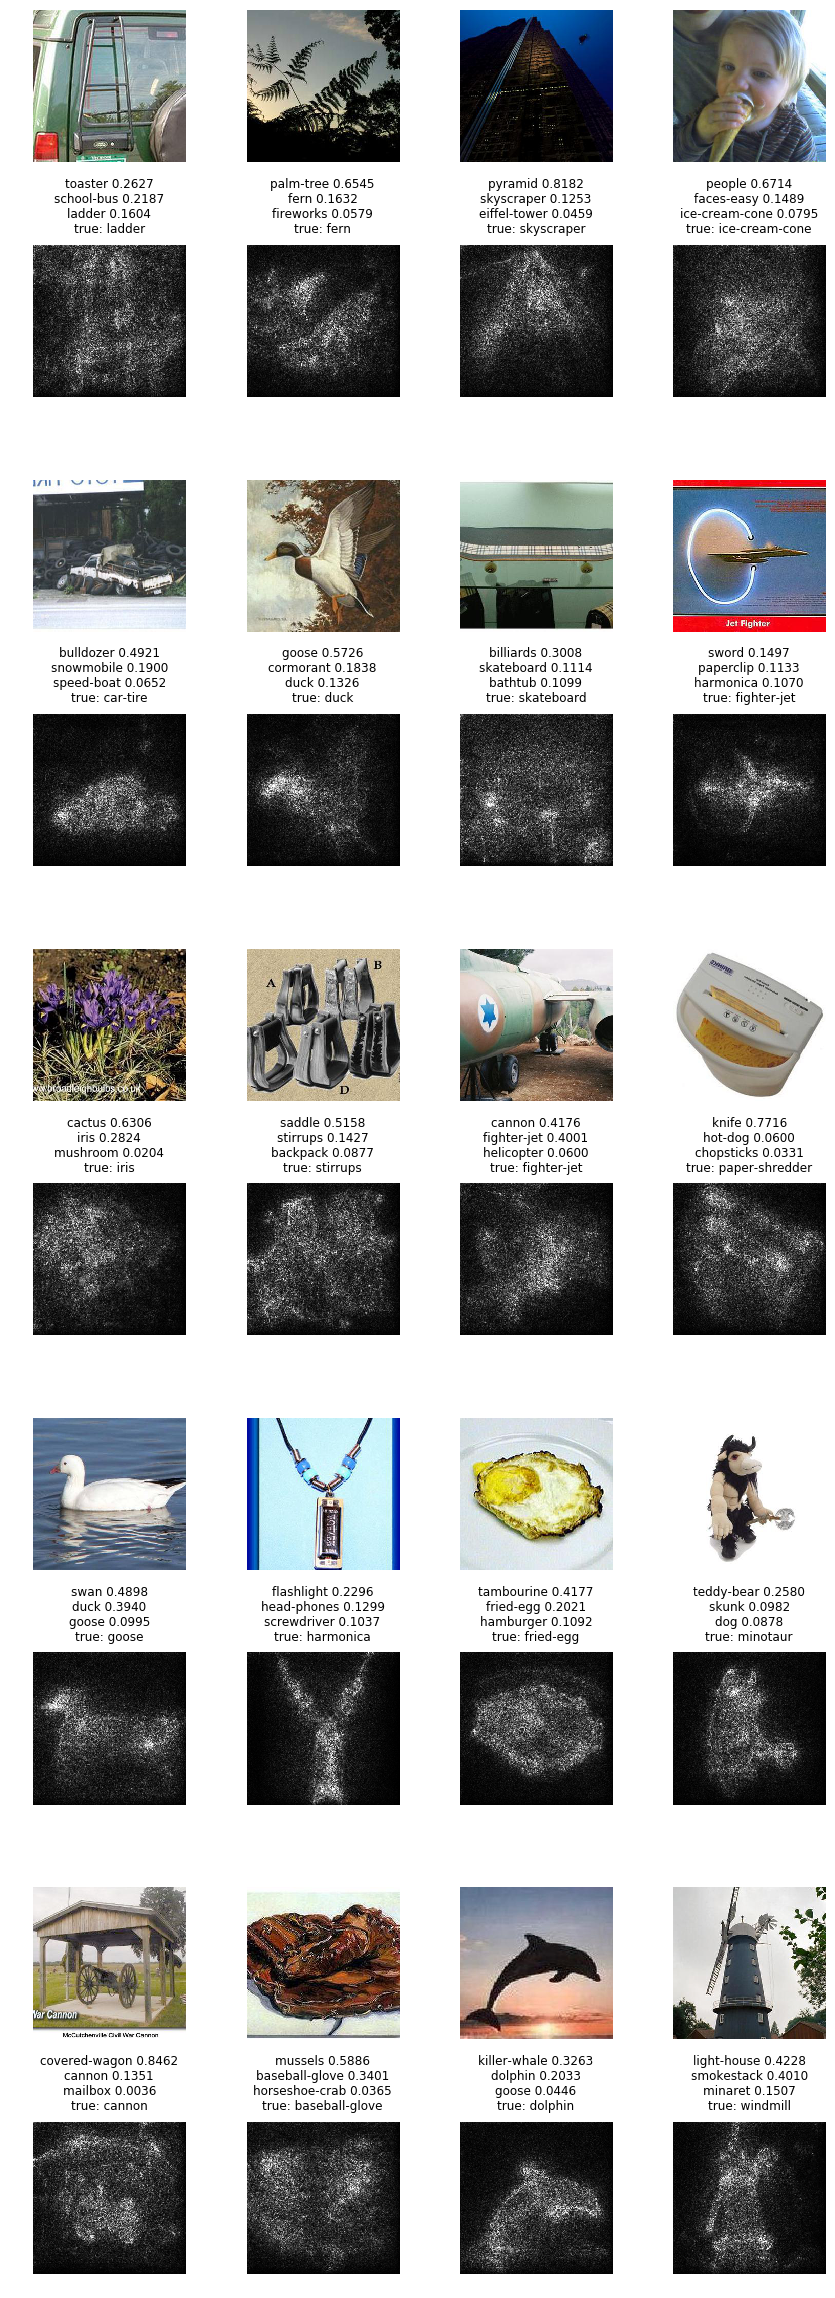

In [17]:
show(
    images, classes, image_grads, image_preds, decode, 
    file_to_save='sensitivity_maps2.png'
)